In [1]:
include("../Inversion/Plot.jl")
include("Spectral-Kuramoto-Sivashinksy.jl")

Solve! (generic function with 1 method)

# Kuramoto-Sivashinksy Equation

We consider the 1D Kuramoto-Sivashinksy equation on a periodic domain $D = [0,L]$:

$$
\begin{equation*}
\begin{split}
    &\frac{\partial u}{\partial t} = -\frac{1}{2}\partial u^2  - \nu_2\partial^2 u -  \nu_4\partial^4 u \\
    \end{split}
\end{equation*}
$$
It is worth mentioning $\int u dx$ is conserved. Let introduce the linear operator $\mathcal{L}$


Assume the domain is discretized by $N_x+1$ uniform grids with grid points

$$
\begin{align*}
&0 = x_0 < x_1 <\cdots < x_{N_x} = L_x
\end{align*}
$$

For the convinence of applying Discrete Fourier Transform, we rewrite the solution of $u$ as following 

$$
u = \frac{1}{N_x}\sum_{k_x=-N_x/2}^{N_x/2-1} \hat{u}_{k_x}(t)  e^{i 2\pi k_x\frac{x}{L_x}}
$$

Kuramoto-Sivashinksy Equation can be written in the Fourier space, as following

$$
\begin{equation*}
\begin{split}
    &\frac{\partial \hat{u}}{\partial t} = -\frac{1}{2}\bigl(i 2\pi \frac{k_x}{L_x}\bigr)\widehat{u^2}  - \nu_2\bigl(i 2\pi \frac{k_x}{L_x}\bigr)^2 \hat{u} -  \nu_4\bigl(i 2\pi \frac{k_x}{L_x}\bigr)^4 \hat{u} \\
    \end{split}
\end{equation*}
$$


Let deonte the linear ($\hat{L}$) and nonlinear ($\hat{N}$) term 

$$
\hat{L}\hat{u} = - \nu_2\bigl(i 2\pi \frac{k_x}{L_x}\bigr)^2 \hat{u} -  \nu_4\bigl(i 2\pi \frac{k_x}{L_x}\bigr)^4 \hat{u}
\qquad 
\hat{N}(\hat{u}, t) = -\frac{1}{2}\bigl(i 2\pi \frac{k_x}{L_x}\bigr)\widehat{u^2}
$$

The Crank-Nicholson-Adam Bashforth scheme can be written as 

$$
\begin{equation*}
\begin{split}
    &\frac{\partial \hat{u}}{\partial t} = \hat{L}(t) + \hat{N}(t) \\
    &\frac{\hat{u}_{n+1} - \hat{u}_{n} }{\Delta t} = \frac{1}{2}(\hat{L}\hat{u}_n + \hat{L}\hat{u}_{n+1}) + \frac{3}{2}\hat{N}_n - \frac{1}{2}\hat{N}_{n-1} \\
    &\Bigl(I - \frac{\Delta t \hat{L}}{2}\Bigr)\frac{\hat{u}_{n+1} - \hat{u}_{n} }{\Delta t} = \hat{L}\hat{u}_n  + \frac{3}{2}\hat{N}_n - \frac{1}{2}\hat{N}_{n-1} \\
    \end{split}
\end{equation*}
$$

In [26]:
####################################
ν₂=1.0;     # viscosity
ν₄=1.0;     # viscosity
N_x=1024;       # resolution in x
Δt=0.05;    # time step
T=1000.0;        # final time
method="Crank-Nicolson-Adam-Bashforth"  # RK4 or Crank-Nicolson
Lx = 100.0

mesh = Spectral_Mesh(N_x, Lx)
Δx, xx = mesh.Δx, mesh.xx

u0 = cos.((2 * pi * xx) / Lx) + 0.1 * cos.((4 * pi * xx) / Lx)


solver = Spectral_KS_Solver(mesh, u0, ν₂, ν₄)  

N_t = Int64(T/Δt)

u_all = zeros(Float64, N_t, N_x)
u_hat_all = zeros(ComplexF64, N_t, N_x)

for i = 1:N_t
    Solve!(solver, Δt, method)
    
    u_all[i, :] .= solver.u
    u_hat_all[i, :] .= solver.u_hat
end



## Solution

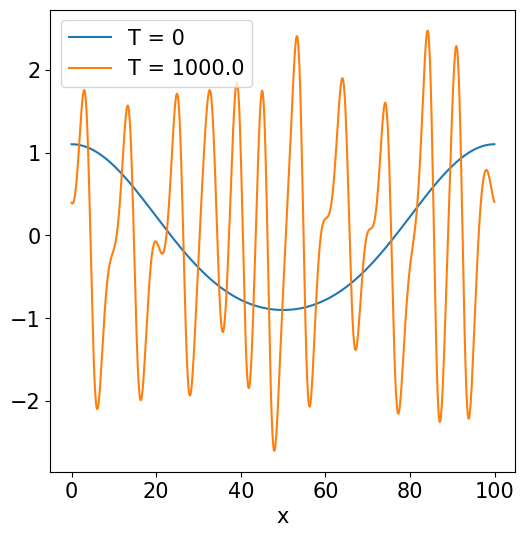

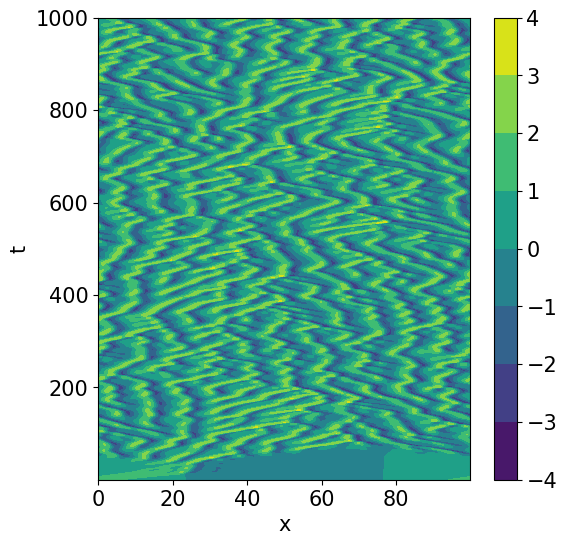

PyObject <matplotlib.colorbar.Colorbar object at 0x1acbe6100>

In [27]:
fig, ax = PyPlot.subplots(nrows=1, ncols=1, sharex=false, sharey=false, figsize=(6,6))
ax.plot(xx, u0, label="T = 0")
ax.plot(xx, solver.u, label="T = "*string(T))
ax.set_xlabel("x")
ax.legend()



T, X = repeat(Δt*Array(1:div(N_t, save_every)), 1, N_x), repeat(xx, 1, div(N_t, save_every))' 
fig, ax = PyPlot.subplots(nrows=1, ncols=1, sharex=false, sharey=false, figsize=(6,6))
cs = ax.contourf(X, T, u_all, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("t")

fig.colorbar(cs)

# (Time averaged ) auto correlation

$$
\begin{align*}
C(x) &= \frac{1}{T}\int_0^T \int_0^L u(z,t) u(z+x, t) dz dt
\end{align*}
$$


In the convention of our code (```fft``` and ```ifft```)
$$
u = \frac{1}{N_x}\sum_{k_x=-N_x/2}^{N_x/2-1} \hat{u}_{k_x}(t)  e^{i 2\pi k_x\frac{x}{L_x}}
$$

We have 
$$
\begin{align*}
C(x) &= \frac{1}{T}\int_0^T \int_0^L u(z,t) u(z+x, t) dz dt \\
     &= \frac{1}{TN_x^2}\int_0^T \int_0^L \sum_{k\in{Z}}  \hat{u}_{k}(t)  e^{i2\pi k\frac{z}{L}} \sum_{k\in{Z}}  \hat{u}_{k}(t)  e^{i2\pi k\frac{z + x}{L}} dz dt  \\
     &= \frac{ L}{TN_x^2}\int_0^T   \sum_{k\in{Z}} \lVert \hat{u}_{k} \rVert^2 e^{i2\pi k\frac{x}{L}} dt
\end{align*}
$$

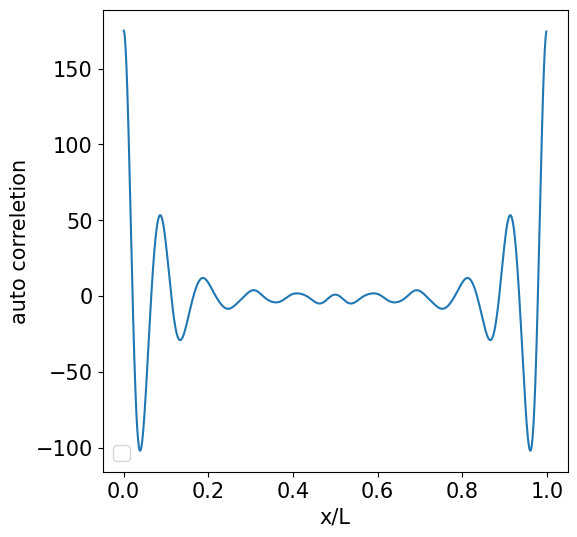

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PyObject <matplotlib.legend.Legend object at 0x1acc52f40>

In [28]:
Cx = zeros(Float64, N_t, N_x)
for i = 1:N_t
    Cx[i, : ] = real(ifft(u_hat_all[i, :] .* conj(u_hat_all[i, :])) ) / N_x
end

N_burn = div(N_t, 10)
auto_correletion = Lx/(N_t - N_burn) * (sum(Cx[N_burn+1:end, :], dims=1)[:])

fig, ax = PyPlot.subplots(nrows=1, ncols=1, sharex=false, sharey=false, figsize=(6,6))
ax.plot(xx/Lx, auto_correletion)
ax.set_xlabel("x/L")
ax.set_ylabel("auto correletion")
ax.legend()

## Energy spectral

$$
\begin{align*}
E(t) &= \frac{1}{L}\int_0^L u'(z,t) u'(z, t) dz 
\end{align*}
$$
here $u'(z,t) = u(z,t) - \bar{u}(t)$, where $\bar{u}(t) = \int u(z,t) dz$. 
In the convention of our code (```fft``` and ```ifft```)
$$
u = \frac{1}{N_x}\sum_{k_x=-N_x/2}^{N_x/2-1} \hat{u}_{k_x}(t)  e^{i 2\pi k_x\frac{x}{L_x}}
$$

We have 
$$
\begin{align*}
E(t) &=  \frac{1}{L}\int_0^L u'(z,t) u'(z, t) dz \\
     &= \frac{1}{LN_x^2} \int_0^L \sum_{k\in{Z}}  \hat{u}_{k}(t)  e^{i2\pi k\frac{z}{L}} \sum_{k\in{Z}}  \hat{u}_{k}(t)  e^{i2\pi k\frac{z}{L}} dz  \\
     &= \frac{1}{N_x^2}  \sum_{k\in{Z}} \lVert \hat{u}_{k} \rVert^2 
\end{align*}
$$

For each wavenumber, we have $E(k) = \frac{1}{N_x^2} \lVert \hat{u}_{k} \rVert^2 $.



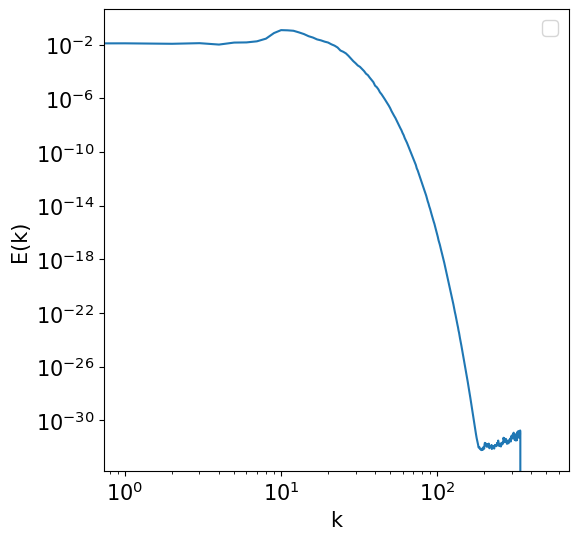

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PyObject <matplotlib.legend.Legend object at 0x1acc7a3a0>

In [29]:
Ex = zeros(Float64, N_t, N_x)
for i = 1:N_t
    Ex[i, : ] = (u_hat_all[i, :] .* conj(u_hat_all[i, :])) / (N_x^2)
end

N_burn = div(N_t, 10)
energy_spectral = 1/(N_t - N_burn) *(sum(Ex[N_burn+1:end, :], dims=1)[:])


fig, ax = PyPlot.subplots(nrows=1, ncols=1, sharex=false, sharey=false, figsize=(6,6))
ax.loglog(energy_spectral[1:div(N_x, 2)])
ax.set_xlabel("k")
ax.set_ylabel("E(k)")
ax.legend()